<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-results" data-toc-modified-id="Load-the-results-1">Load the results</a></span><ul class="toc-item"><li><span><a href="#Metrics" data-toc-modified-id="Metrics-1.1">Metrics</a></span></li></ul></li></ul></div>

In [70]:
import torch
import seaborn as sns
from src.models import PJPE
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the results

In [20]:
t_data = torch.load("../src/results/t_data_absurd-music-3244_bh_False_mj_0.pt")
print(list(t_data.keys()))

['recon_2d', 'recon_3d', 'novel_2d', 'target_2d', 'target_3d', 'z', 'action', 'recon_3d_org']


In [39]:
# Get metrics
pjpe_n_j = PJPE(t_data['recon_3d'], t_data['target_3d'])
pjpe_j = pjpe.mean(dim=0)
pjpe_n = pjpe.mean(dim=1)

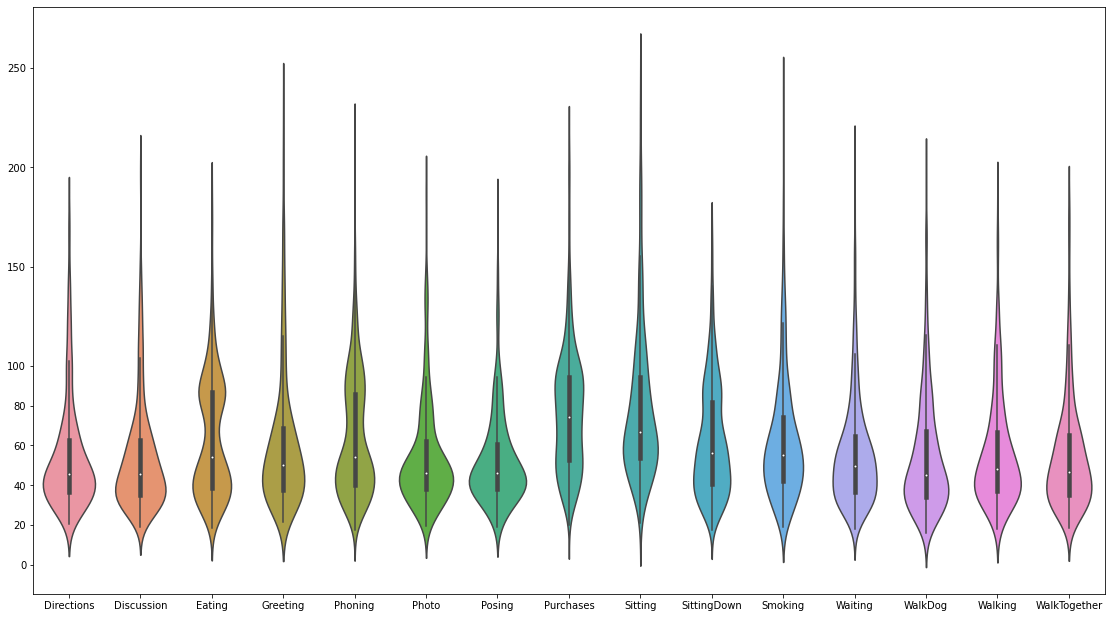

In [128]:
ax = sns.violinplot(t_data['action'].numpy(), pjpe_n)

ticks = list(np.arange(100, pjpe_n.max()+50, 50))
ticks.extend(np.arange(0,100,20))
_ = plt.setp(ax,yticks=sorted(ticks))
_ = ax.set_xticklabels(["Directions", "Discussion", "Eating", "Greeting", "Phoning", "Photo", "Posing", "Purchases",
                             "Sitting", "SittingDown", "Smoking", "Waiting", "WalkDog", "Walking", "WalkTogether"])
_ = plt.savefig("../src/results/violin_pjpe.svg", format='svg', dpi=1200)